<a href="https://colab.research.google.com/github/pyagoubi/Motorcycle-data/blob/main/Motorcycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
%%capture
pip install geopandas

In [112]:
# Importing librarys and loading data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import geopandas
import geopy.distance
import seaborn as sns

data = pd.read_csv('/content/drive/MyDrive/upwork1/DATA1.TXT', sep=',')
data['Gx clean'] = data['Gx']-data['Gx Cal']
data['Gy clean'] = data['Gy']-data['Gy Cal']


#Parameters

shift_a = 30  # how many steps forward and backwards are used to calculate angles, the closer the curves (back 2 back) the lower should this parameter be
degree_min = 50  # minimum angle degree to be considered for a corner
min_samples = 50 # for DBSCAN minimum angle-samples in the same area to be considered a true corner
cluster_area = 0.02 # for DBSCAN proximity to detect true corners
proximity = 20 # proximity around reference point to detect local minima (end of breaking phase)


# Identifying Corners

Corners are identified by three steps  
1. Calculating angles between consecutive timesatmps
2. Identifying true corner clusters with DBSCAN
3. Calculating corner reference points as centroids of corner points

## 1 Calculating angles

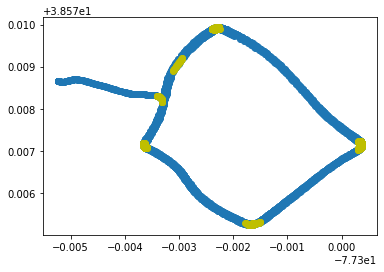

In [113]:
def angle_corner(df, shift_parameter = shift_a, degree_pm = degree_min):

  df['degrees'] = 0
  df['corner_a'] = 0

  for i in df['SessionID'].unique():
    
    
    data = df[df['SessionID'] == i]

    # Convert the points to numpy latitude/longitude radians space

    data['Lat converted'] = np.radians(data['Latitude'])
    data['Lon converted'] = np.radians(data['Longitude'])

    #past reference point
    data['Lat before'] = data['Lat converted'].shift(shift_parameter)
    data['Lon before'] = data['Lon converted'].shift(shift_parameter)

    #future reference point
    data['Lat after'] = data['Lat converted'].shift(-shift_parameter)
    data['Lon after'] = data['Lon converted'].shift(-shift_parameter)


    # Vectors in latitude/longitude space
    data['vector prev'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat before', 'Lon before']])).tolist()
    data['vector past'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat after', 'Lon after']])).tolist()


    for j in range(len(data)):
      if np.isnan(data['vector prev'][j][0]) == False:
        data.iloc[j, data.columns.get_loc('degrees')] = np.degrees(math.acos(np.dot(data['vector prev'][j], data['vector past'][j]) / (np.linalg.norm(data['vector prev'][j]) * np.linalg.norm(data['vector past'][j]) +1e-20)))
        #print(data.iloc[i, data.columns.get_loc('degrees')])
    
    data.loc[(data['degrees'] < (180 - degree_pm) )  |  (data['degrees'] > (180 + degree_pm) )    , 'corner_a'] = 1

    df.loc[df['SessionID'] == i, 'corner_a'] = data['corner_a']
    df.loc[df['SessionID'] == i, 'degrees'] = data['degrees'] 


  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['corner_a'] == 1), 'Longitude'], y=df.loc[(df['corner_a'] == 1),'Latitude'], color = 'y')  

  return df

data = angle_corner(data, shift_parameter = shift_a, degree_pm = degree_min)

## 2 Identifying true corners with DBSCAN


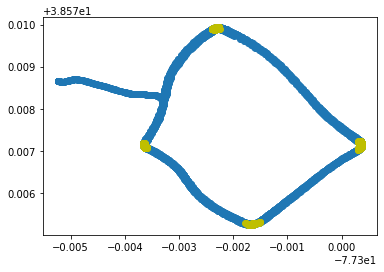

In [114]:
def true_corners(df, min_samples=min_samples, cluster_area = cluster_area):
  
  coords = df.loc[df['corner_a']==1, ['Longitude', 'Latitude']]
  db = DBSCAN(eps=cluster_area/6371., min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(df.loc[df['corner_a']==1, ['Longitude', 'Latitude']]))

  cluster_labels = db.labels_

  df['Corner Number'] = -1
  num_clusters = len(set(cluster_labels))
  clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

  df.loc[df['corner_a']==1, 'Corner Number'] = cluster_labels

  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['Corner Number'] >= 0), 'Longitude'], y=df.loc[(df['Corner Number'] >= 0),'Latitude'], color = 'y') 

  return df

data = true_corners(data)


## 3 Determine Reference points 

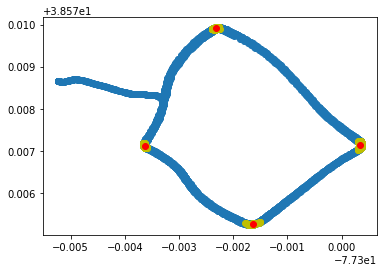

In [115]:
def centroids(df):

  corners_df = pd.DataFrame()

  centroid_x = []
  centroid_y = []

  corners = df['Corner Number'].unique().tolist()
  corners.remove(-1)

  for corner in corners:
    point = MultiPoint(geopandas.points_from_xy(df.loc[df['Corner Number'] == corner,'Longitude'], df.loc[df['Corner Number'] == corner, 'Latitude'] , crs="EPSG:4326" ))
    centroid_x.append(point.centroid.x)
    centroid_y.append(point.centroid.y)
    del point
  
  corners_df['Corner Nr'] = corners
  corners_df['Longitude'] = centroid_x
  corners_df['Latitude'] = centroid_y

  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['Corner Number'] >= 0), 'Longitude'], y=df.loc[(df['Corner Number'] >= 0),'Latitude'], color = 'y') 
  plt.scatter(x=corners_df['Longitude'], y=corners_df['Latitude'], color = 'r')

  return corners_df

reference_points = centroids(data)



# Calculating metrics

## Determine Breaking Points

Breaking points are considered local speed minima within a range of *proximity* meters within a corner reference point. Ths is considered the endpoint of the breaking and starting point of acceleration.

In [116]:
# Calculate distances between reference points and track

def distances(df, ref):
  distances=[]
  corner_no = reference_points['Corner Nr']
  coordinates = list(zip(data['Latitude'], data['Longitude']))
  
  for i in corner_no:
    corner_lon = ref.loc[ref['Corner Nr']== i , 'Longitude'].values[0]
    corner_lat = ref.loc[ref['Corner Nr']== i , 'Latitude'].values[0]
    cent = (corner_lat,corner_lon)
    for j in range(len(data)):
      dist = geopy.distance.geodesic(cent, coordinates[j]).m   
      distances.append(dist)
    df[f'Distance from corner {i}'] = distances
    distances=[]

  return df
       

In [117]:
data = distances(data, reference_points)

In [118]:
#All values after passing the closest point to centroid are multiplied by -1
def adjust_distance(df, corner_no): 
  df['most_controid'] = 0
  
  for j in corner_no:
    minids = df.groupby('Lap Number')[f'Distance from corner {j}'].apply(lambda x: x.idxmin())
    for i in df['Lap Number'].unique():
      df.loc[(df.index <= minids[i])  & (df['Lap Number'] == i) ,f'Distance from corner {j}'] *= -1
      df.loc[df.index == minids[i],  'most_controid'] = j
  
  return df



In [119]:
corner_no = reference_points['Corner Nr']
data = adjust_distance(data, corner_no)

<function matplotlib.pyplot.show(close=None, block=None)>

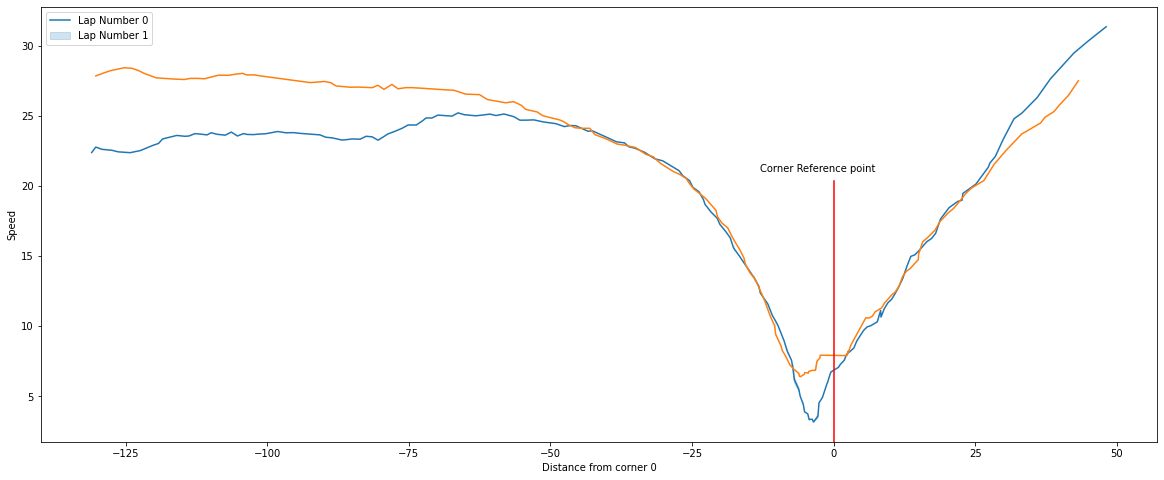

In [120]:
# Plot example


f, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.lineplot(x='Distance from corner 0', y = 'Speed', data = data[(data['Lap Number']== 1 )  &  (((data['Distance from corner 0'] >-200) &  (data['Distance from corner 0'] <= 0))  | 
                               ((data['Distance from corner 0'] < 50) &  (data['Distance from corner 0'] > 0))  )]  )
sns.lineplot(x='Distance from corner 0', y = 'Speed', data = data[(data['Lap Number']== 2 )  &  (((data['Distance from corner 0'] >-200) &  (data['Distance from corner 0'] <= 0))  | 
                               ((data['Distance from corner 0'] < 50) &  (data['Distance from corner 0'] > 0))  )]  )


plt.axvline(x = 0, color = 'r', ymax=0.6)
plt.text(-13,21,'Corner Reference point')

ax.legend(labels=[f'Lap Number {i}' for i in range(2)])
plt.show



#sns.lineplot(x='Distance from corner 1', y = 'Speed', data = data[data['Lap Number']== 1])

In [162]:
def flag_breaking_points(df, corner_no, proximity):
  df['flag breaking point'] = ''

  for i in corner_no:
    for j in df['Lap Number'].unique():
      df.iloc[df.loc[(df['Lap Number'] ==j)  & (df[f'Distance from corner {i}'].abs() < proximity)  , 'Speed'].idxmin(), df.columns.get_loc('flag breaking point')] = i

  return df

data = flag_breaking_points(data, corner_no, proximity)


In [243]:
def calculate_metrics(df, corner_no):
  b= 5 # shift

  metrics = pd.DataFrame(columns=['Index', 'SessionID', 'Lap Number', 'Corner Number', 'Breaking Distance', 'Acceleration'])

  for i in corner_no:
    for j in df['Lap Number'].unique():
      aind = df[ (df['Lap Number'] == j)   &  (df['flag breaking point'] == i)].index

      delta_v = df.iloc[ aind + 20, df.columns.get_loc('Speed')].values[0] - df.iloc[ aind, df.columns.get_loc('Speed')].values[0]
      delta_t = (df.iloc[aind + 20, df.columns.get_loc('Time')].values[0] - df.iloc[aind, df.columns.get_loc('Time')].values[0])/pd.Timedelta(seconds=1)
      acc = delta_v/delta_t

      len_df = len(    df[df['Lap Number'] == j].iloc[:aind.values[0] - 12 - 1, :])
      for k in range(len_df): 
        a = df.iloc[ aind - k - b, df.columns.get_loc('Speed')].values[0]
        b = df.iloc[ aind - k - b -5, df.columns.get_loc('Speed')].values[0]

        if a>b:
          breaking_distance = max(0, df.iloc[aind, df.columns.get_loc(f'Distance from corner {i}') ].values[0] - df.iloc[aind - k -b, df.columns.get_loc(f'Distance from corner {i}') ].values[0])
          met = [aind.values[0] - k -b, df.iloc[aind - k, df.columns.get_loc(f'SessionID')].values[0], j, i,  breaking_distance, acc ]
          metrics.loc[len(metrics)] = met
          break

  
  
  
  display(metrics)

  return metrics

data['Time'] =pd.to_datetime(data['Time'])
metrics = calculate_metrics(data, corner_no)



,Index,SessionID,Lap Number,Corner Number,Breaking Distance,Acceleration
0,56.01,0.0,1.0,0.0,54.650665,2.024324
1,842.95,0.0,2.0,0.0,72.171163,1.294118
2,1496.84,0.0,3.0,0.0,85.587814,0.181818
3,2384.05,0.0,4.0,0.0,0.000000,1.084000
4,3296.59,0.0,5.0,0.0,1.049923,1.984000
5,284.91,0.0,1.0,1.0,10.006925,1.357692
6,983.76,0.0,2.0,1.0,6.372961,1.820000
7,1698.45,0.0,3.0,1.0,198.847671,0.333333
8,2554.79,0.0,4.0,1.0,206.737408,0.672000
9,3401.66,0.0,5.0,1.0,276.482118,1.426923
